# VARS

In [1]:
MODEL_PATH = f"./records/53c44db2-4fed-4516-944e-e5612b34086f"

# Train/Val Metrics

Text(0.5, 1.0, 'Train/Val Loss x Epochs')

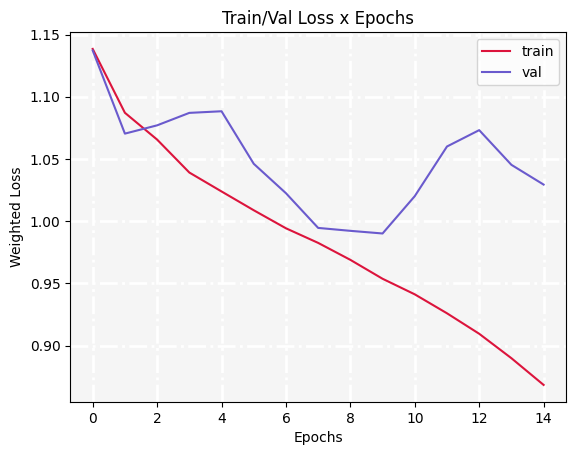

In [2]:
import pickle
import matplotlib.pyplot as plt

with open(f"{MODEL_PATH}/history", "rb") as f:
    h = pickle.load(f)
plt.xlabel("Epochs")
plt.ylabel("Weighted Loss")
plt.gca().set_facecolor("whitesmoke")
# plt.gca().set_ylim(0, 1)
plt.grid(color='w', linewidth=2, linestyle='-.')
plt.plot(h['loss'], c='crimson')
plt.plot(h['val_loss'], c='slateblue')
plt.legend(['train', 'val'])

plt.title("Train/Val Loss x Epochs")

# Test 

In [3]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

with open(f"{MODEL_PATH}/test_metrics", "rb") as f:
    var = pickle.load(f)

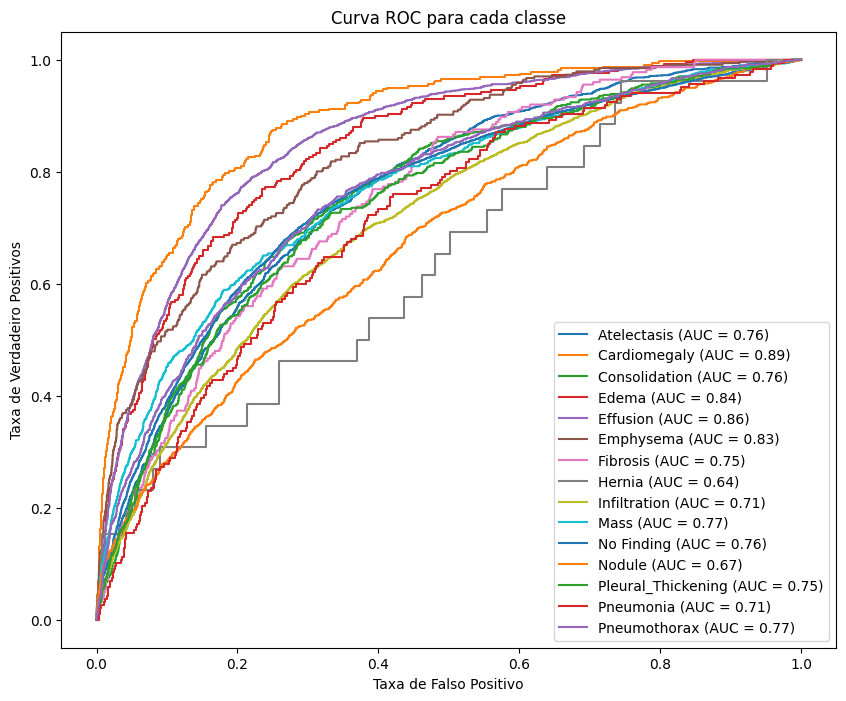

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import  roc_curve

# Calculando a curva AUC
plt.figure(figsize=(10, 8))
# Plotando as curvas ROC
for i in range(len(var['labels'])):
    fpr, tpr, _ = roc_curve(var['groun_truth'][:, i], var['predictions'][:, i])
    plt.plot(fpr, tpr, label=var['labels'][i] + ' (AUC = {:.2f})'.format(var['auc_scores'][i]))

# Adicionando legendas e título ao gráfico
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivos')
plt.title('Curva ROC para cada classe')
plt.legend()

# Exibindo o gráfico
# plt.show()
plt.savefig('curva-rock.png', dpi=80)

In [9]:
var['auc_micro']

0.8095544701329986

# RE-TRAIN

##############################################################################################################################

In [12]:
from train import create_model
import tensorflow as tf
from train import split_dataset
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from catboost.utils import get_roc_curve

In [3]:
print("Número de GPUs disponíveis: ", len(
tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)


Número de GPUs disponíveis:  2
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [7]:
labels = [
    "Atelectasis",
    "Cardiomegaly",
    "Consolidation",
    "Edema",
    "Effusion",
    "Emphysema",
    "Fibrosis",
    "Hernia",
    "Infiltration",
    "Mass",
    "No Finding",
    "Nodule",
    "Pleural_Thickening",
    "Pneumonia",
    "Pneumothorax"] 

In [8]:
df_train, df_test, df_val = split_dataset()

In [10]:
datagen = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)

train_generator = datagen.flow_from_dataframe(
    dataframe=df_train,
    directory = None,
    x_col='path',
    y_col= labels,
    class_mode= "raw",
    target_size=(224,224),
    batch_size=8,
    shuffle=True,
)



Found 78873 validated image filenames.
Found 10953 validated image filenames.
Found 22294 validated image filenames.


In [36]:
val_generator = datagen.flow_from_dataframe(
    dataframe=df_val,
    directory = None,
    x_col='path',
    y_col= labels,
    class_mode= "raw",
    target_size=(224,224),
    batch_size=1,
    shuffle=False,
)


test_generator = datagen.flow_from_dataframe(
    dataframe=df_test,
    directory = None,
    x_col='path',
    y_col= labels,
    class_mode= "raw",
    target_size=(224,224),
    batch_size=1,
    shuffle=False,
)

Found 10953 validated image filenames.
Found 22294 validated image filenames.


In [4]:
model = create_model()

2024-01-30 12:15:00.555002: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-30 12:15:00.555429: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-30 12:15:00.555925: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-30 12:15:00.556356: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [25]:
import tensorflow.python.keras.backend as K
import uuid, os, utils

In [26]:
def compute_class_freqs(labels):
    N = labels.shape[0]

    positive_frequencies = np.sum(labels, axis=0) / N
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies


freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights
neg_contribution = freq_neg * neg_weights

def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)

    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value.

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0
        y_true = tf.cast(y_true, tf.float32)

        for i in range(len(pos_weights)):

          loss += K.mean(-(pos_weights[i] *y_true[:,i] * K.log(y_pred[:,i] + epsilon)
          + neg_weights[i]* (1 - y_true[:,i]) * K.log( 1 - y_pred[:,i] + epsilon))) #complete this line
        return loss


    return weighted_loss

In [27]:
model = create_model()
# callbacks setup
MODEL_PATH = "records"
model_name = f"model_{uuid.uuid4()}"
CHECKPOINT_PATH = f"{MODEL_PATH}/{model_name}"
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

checkpoint = tf.keras.callbacks.ModelCheckpoint(f"{CHECKPOINT_PATH}/weights_best.hdf5",
    monitor = 'val_loss',
    save_weights_only = True,
    mode='auto',
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    # min_delta=0.001,
    patience=5,
    restore_best_weights=True
)

model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights),  metrics=[tf.keras.metrics.AUC(multi_label=True)])

In [28]:
model_name

'model_6fec7ae6-ab06-46f9-b256-bf3130a60c4d'

In [29]:
H = model.fit(train_generator, 
    validation_data = val_generator,
    epochs = 1,
    callbacks=[checkpoint,
            early_stopping]
    )

9860/9860 [==============================] - ETA: 0s - loss: 1.2115 - auc_1: 0.6199
Epoch 1: saving model to records/model_6fec7ae6-ab06-46f9-b256-bf3130a60c4d/weights_best.hdf5
9860/9860 [==============================] - 1037s 104ms/step - loss: 1.2115 - auc_1: 0.6199 - val_loss: 1.1811 - val_auc_1: 0.7029


In [30]:
utils.save_history(H.history, CHECKPOINT_PATH)

In [31]:
predictions = model.predict(test_generator, verbose=1)

22294/22294 [==============================] - 282s 13ms/step


In [37]:
predictions_val = model.predict(val_generator, verbose=1)

10953/10953 [==============================] - 133s 12ms/step


In [34]:
from sklearn.metrics import roc_auc_score

In [38]:
auc_score = roc_auc_score(val_generator.labels, predictions_val, average='macro')
auc_score

0.7029236799375232

In [40]:
labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [39]:
auc_scores = roc_auc_score(val_generator.labels, predictions_val, average=None)
auc_scores

array([0.68065409, 0.76056213, 0.74200105, 0.85140512, 0.77408287,
       0.73392859, 0.6608345 , 0.71334919, 0.66093838, 0.62346761,
       0.70528275, 0.62317781, 0.61028328, 0.66584911, 0.73803872])

In [41]:
for disease,auc in zip(labels,auc_scores):
    print(f'{disease}: {auc}')

# results = {
#     "groun_truth" : test_generator.labels,
#     "predictions" : predictions,
#     "auc_scores" : auc_scores,
#     "labels" : labels
# }
# utils.store_test_metrics(results, path=CHECKPOINT_PATH) 

Atelectasis: 0.680654089466052
Cardiomegaly: 0.7605621304598122
Consolidation: 0.7420010459256443
Edema: 0.8514051231588232
Effusion: 0.7740828668169257
Emphysema: 0.733928590843363
Fibrosis: 0.6608344972506386
Hernia: 0.7133491889254786
Infiltration: 0.6609383789417954
Mass: 0.6234676051646846
No Finding: 0.7052827543353899
Nodule: 0.6231778105745966
Pleural_Thickening: 0.6102832840338189
Pneumonia: 0.6658491118426949
Pneumothorax: 0.7380387213231311


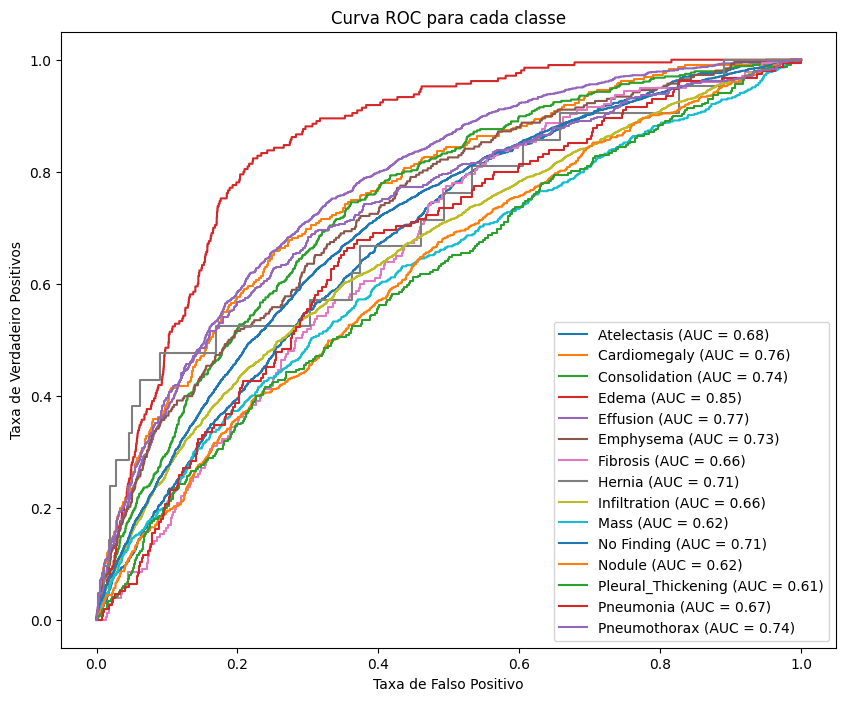

<Figure size 640x480 with 0 Axes>

In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import  roc_curve

# Calculando a curva AUC
plt.figure(figsize=(10, 8))
# Plotando as curvas ROC
for i in range(len(labels)):
    fpr, tpr, _ = roc_curve(val_generator.labels[:, i], predictions_val[:, i])
    plt.plot(fpr, tpr, label=labels[i] + ' (AUC = {:.2f})'.format(auc_scores[i]))

# Adicionando legendas e título ao gráfico
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivos')
plt.title('Curva ROC para cada classe')
plt.legend()

# Exibindo o gráfico
plt.show()
plt.savefig('curva-rock.png', dpi=80)